# Projet HDDL : DeepMoji

5GMM - Emma Espinasse, Elizabeth Fu, Paul Larousse, Wilhelm Støren

Presentation on 19/01/2021

### What is Deepmoji ?

The idea behind Deepmoji is that in many cases, emojis serve as a proxy for the emotional contents of a text. Deepmoji is an available pre-trained model that can be used for different target tasks.

It was pretrained on the classification task of predicting which emoji were initially part of a text. It gives the top 5 most likely emojis for the text, as well as the probability for each suggested emoji. The study of the authors showed that this pretraining helped to have a better prediction for the target task.

### Requirements
- Python 2.7 with pip
- Theano (0.9+) or Tensorflow (1.3+)
- Keras
- scikit-learn
- h5py
- text-unidecode
- emoji

## Model architecture
The model is based on the LSTM (Long-Short Term Memory) model that has been successful at many NLP tasks.

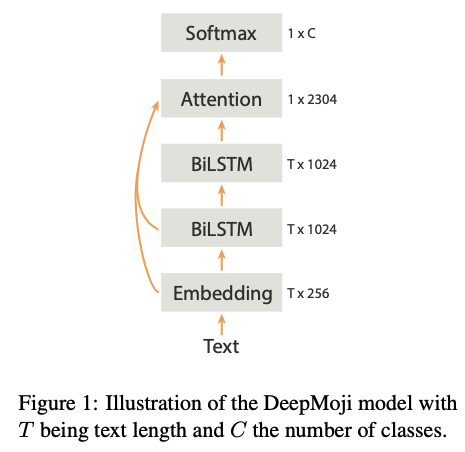

- (INPUT LAYER) embedding layer
    - 256 dimensions
    - to project each word into a vector space
    - activation function: tanh -> to constraint each embedding dimension within [-1,1]
    
- bidirectional LSTM layer
    - 1024 hidden layers (512 in each direction)
    
- bidirectional LSTM layer
    - 1024 hidden layers (512 in each direction)
    
- attention layer
    - takes all previous layers as input using skip-connections
    - lets the model decide the importance of each word for the prediction task by weighing them
    - output: representation vector $v$ (high level encoding of the entire text)

- (OUTPUT LAYER) softmax layer
    - for classification (here a multi-classification problem with C classes)



### LSTM

Long-short term memory (LSTM) is a specific type of recurrent neural networks (RNN), and is very common in NLP as it is specisalised in prossessing sequential data. In contrast to normal neural networks, in RNN the output is fed back through the network allowing the information passing through the network to persist. This enables RNN to connect previous information to the present task. A LSTM takes this further and can "remember" information for longer periods which is an advantage in NLP. 
LSTM contains different gates and cells: 
* **Memory cell**: "stores" the information running through the unit (from previous time steps).
* **Input gate**: decides which values and to update and their candidate values, and thus controls the new information included in the memory cell.
* **Forget gate**: discard information that is considered unnecessary.
* **Output gate**: the output to the rest of the network based on the memory cell and the two gates above.

In text information does not only read one way, ie. from left to right, which is why the model consideres bidirectional LSTMs.
   
DeepMoji focuses on 64 emojis only. $C = 64$

### Attention layer: ###

__Definition:__ In the current language, attention is the process of focusing only on one or a few things. 

_For example, when we want to count the number of people in a classroom, we only focus on the number of head, we don't need to take the entire body into account._

__The attention layer__ has the same objective. In a sentence, it aims to detect the words that bring the most knowledge. In our case, we want to understand the feeling given off by a sentence. Words such as 'beautiful', 'amazing' or 'bad' will therefore bring a lot of information on the emotionnal meaning of the sentence. 

__Mathematically__ this mechanism, introduced by Bahdanau and al. in 2015, is quite simple. 

When the attention layer constructs the representation of the text, it attributes weights $w_a$ to each word. If we note $h_t$ the representation of the $t^{th}$ word of the sentence, we have:
$$e_t = h_tw_a$$
$e_t$ is here the weighted representation of the word $h_t$.

Using a softmax function, we find the attention importance score $\alpha_i$ of the word:
$$\alpha_i = \frac{exp(e_t)}{\sum_{i=0}^T exp(e_i)}$$
This value $\alpha$ is a probability distribution over the words of a sentence.

To be able to class the sentence, it needs to be reconstructed. A simple sum is needed:
$$v = \sum_{i=1}^T \alpha_i h_i$$
The vector $v$ is called a representation vector and is a high-level encoding of the entire sentence. It is also the input vector of the final softmax layer for classification.
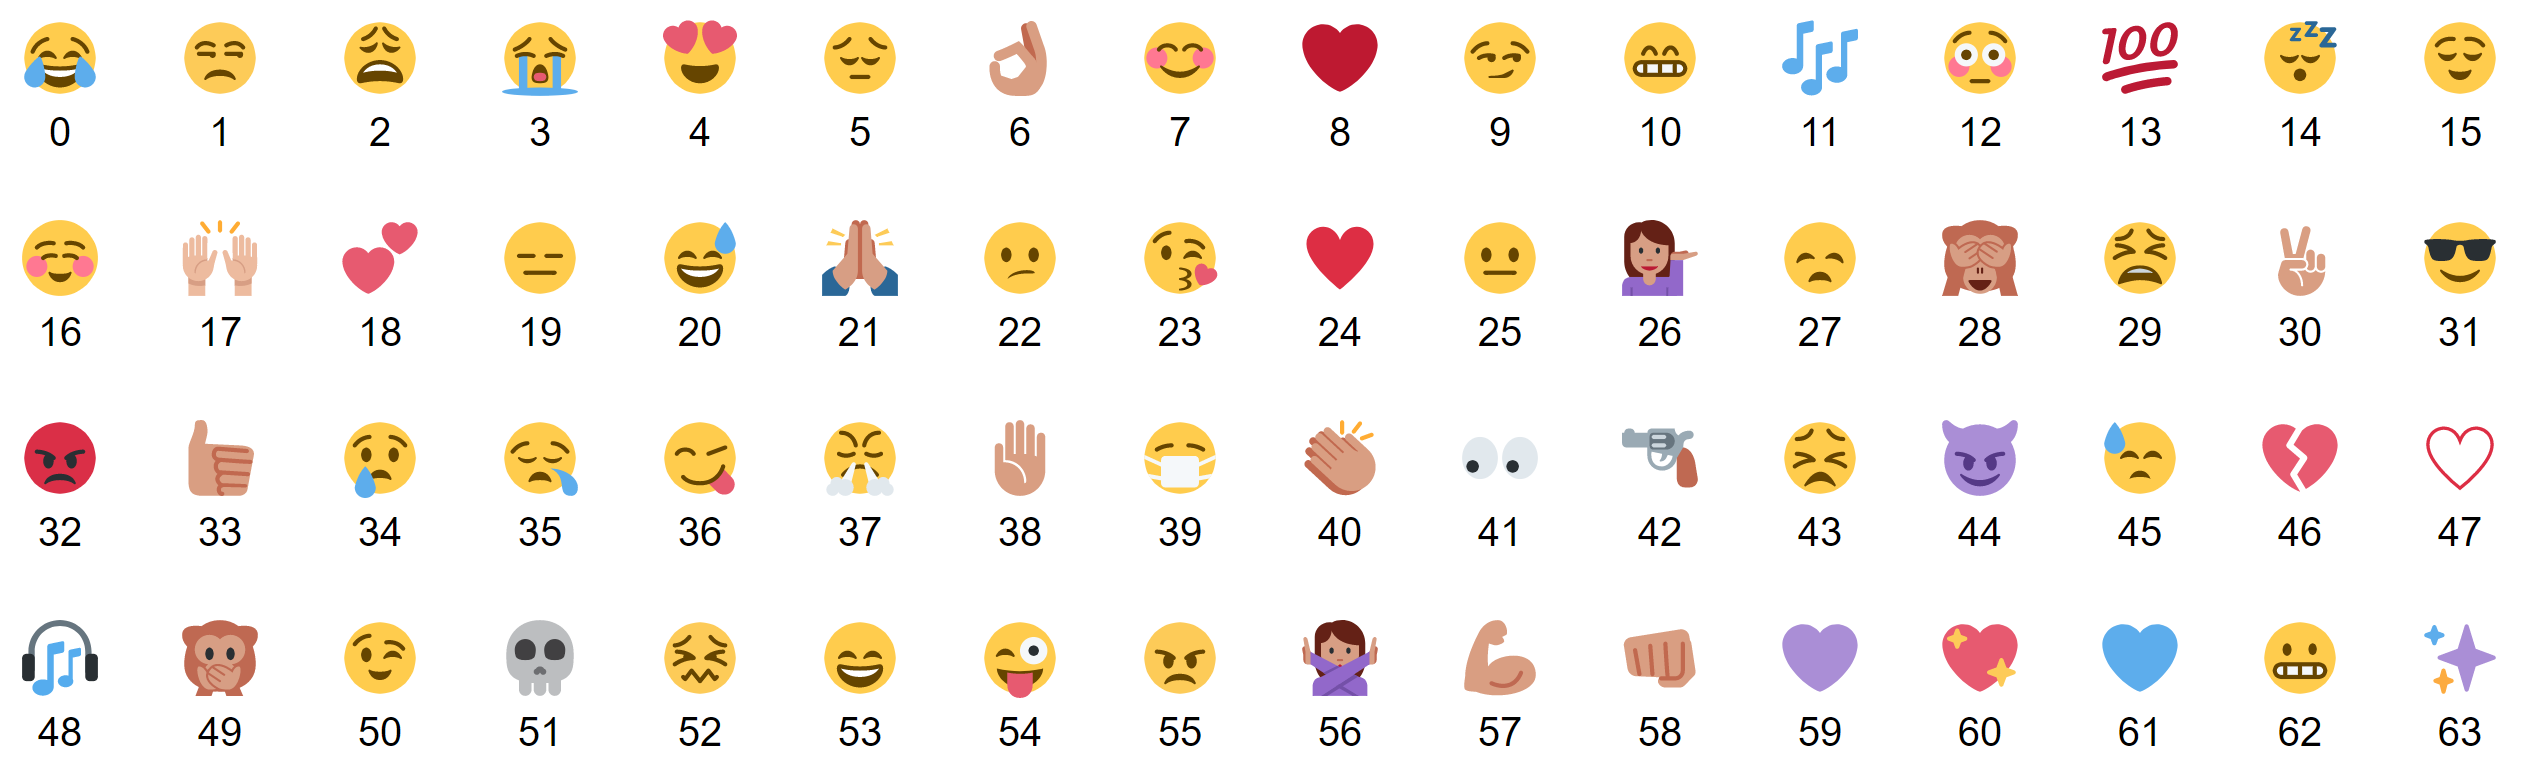
#### List of the 64 most common emoji


## Application of DeepMoji

DeepMoji gives the top 5 most likely emojis for a given text, as well as the probability for each suggested emoji.

Dataset : 1246 million tweets containing one of the given 64 common emojis.

Pre-processing : 
/// à détailler ///

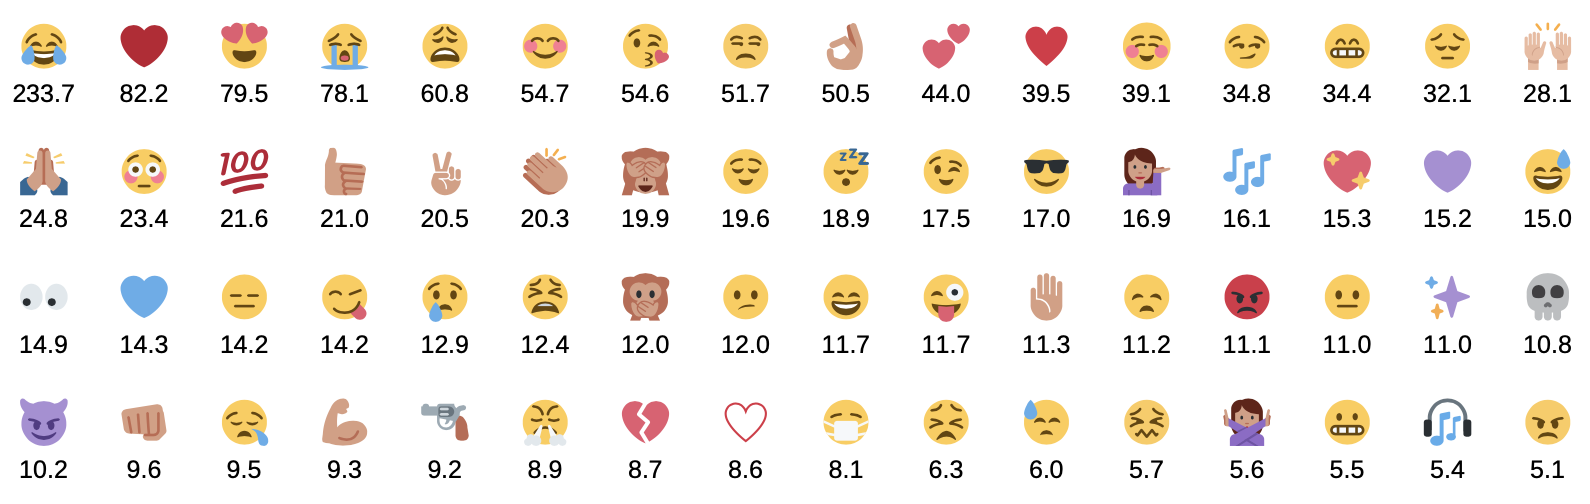

#### Number of tweets in the dataset associated with each emoji (in millions)




In [1]:
from __future__ import print_function, division
#import example_helper
import json
import csv
import numpy as np
from deepmoji.sentence_tokenizer import SentenceTokenizer
from deepmoji.model_def import deepmoji_emojis
from deepmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH

OUTPUT_PATH = 'test_sentences.csv'

TEST_SENTENCES = [u'I feel sick', #normal sentences
                  u'I loved that movie!',
                  u'I love how you never reply back..', # irony and sarcasm
                  u'He is never happy for me, he is such a good friend...',
                  u'This is shit', # comparison between slang and not slang
                  u'This is the shit',
                  u'I can\'t wait for corona to go away'] # test for a new word

def top_elements(array, k):
    ind = np.argpartition(array, -k)[-k:]
    return ind[np.argsort(array[ind])][::-1]

maxlen = 30
batch_size = 32

print('Tokenizing using dictionary from {}'.format(VOCAB_PATH))
with open(VOCAB_PATH, 'r') as f:
    vocabulary = json.load(f)
st = SentenceTokenizer(vocabulary, maxlen)
tokenized, _, _ = st.tokenize_sentences(TEST_SENTENCES)

print('Loading model from {}.'.format(PRETRAINED_PATH))
model = deepmoji_emojis(maxlen, PRETRAINED_PATH)
model.summary()

Using TensorFlow backend.


Tokenizing using dictionary from /Users/efu/Documents/INSA/INSA-5A/HDDL/projet/HDDL_moji/model/vocabulary.json
Loading model from /Users/efu/Documents/INSA/INSA-5A/HDDL/projet/HDDL_moji/model/deepmoji_weights.hdf5.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 256)      12800000    input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 30, 256)      0           embedding[0][0]                  
____________________________________________________________________________________________

In [2]:
print('Running predictions.')
prob = model.predict(tokenized)

# Find top emojis for each sentence. Emoji ids (0-63)
# correspond to the mapping in emoji_overview.png
# at the root of the DeepMoji repo.
print('Writing results to {}'.format(OUTPUT_PATH))
scores = []
for i, t in enumerate(TEST_SENTENCES):
    t_tokens = tokenized[i]
    t_score = [t]
    t_prob = prob[i]
    ind_top = top_elements(t_prob, 5)
    t_score.append(sum(t_prob[ind_top]))
    t_score.extend(ind_top)
    t_score.extend([t_prob[ind] for ind in ind_top])
    scores.append(t_score)
    print(t_score)

with open(OUTPUT_PATH, 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=',', lineterminator='\n')
    writer.writerow(['Text', 'Top5%',
                     'Emoji_1', 'Emoji_2', 'Emoji_3', 'Emoji_4', 'Emoji_5',
                     'Pct_1', 'Pct_2', 'Pct_3', 'Pct_4', 'Pct_5'])
    for i, row in enumerate(scores):
        try:
            writer.writerow(row)
        except Exception:
            print("Exception at row {}!".format(i))

Running predictions.
Writing results to test_sentences.csv
[u'I feel sick', 0.79325443133711815, 39, 52, 43, 27, 45, 0.53741997, 0.10260697, 0.063392378, 0.045469984, 0.044365119]
[u'I loved that movie!', 0.2878316193819046, 4, 16, 8, 6, 40, 0.08005859, 0.055426072, 0.053529911, 0.05083669, 0.047980357]
[u'I love how you never reply back..', 0.39060431718826294, 1, 19, 55, 25, 46, 0.13978004, 0.082515739, 0.062788285, 0.054191161, 0.051329087]
[u'He is never happy for me, he is such a good friend...', 0.61038759350776672, 46, 5, 34, 27, 35, 0.2167147, 0.12788892, 0.11282174, 0.10254616, 0.050416082]
[u'This is shit', 0.31180431321263313, 55, 32, 27, 1, 37, 0.070093207, 0.063969426, 0.060115729, 0.059525676, 0.058100276]
[u'This is the shit', 0.37477060779929161, 48, 11, 6, 31, 9, 0.10890723, 0.096594594, 0.064820789, 0.056501403, 0.047946591]
[u"I can't wait for corona to go away", 0.27680433914065361, 17, 2, 10, 29, 62, 0.059332285, 0.057746291, 0.055291809, 0.054247018, 0.050186936]


DeepMoji gives pretty accurate results.

## Finetuning for further target tasks

We can use DeepMoji for a further target task.

To do so, we need to fine-tune DeepMoji on the supplementary dataset, and we talk about "transfer learning" of the model.

### Transfer learning
It is the term used when a pretrained model is used for a target task.
2 common approaches:
- 'last approach': all layers of the model are frozen when fine-tuning on the target task, except the last layer.
- 'full approach': the full model is unfrozen and we take the pretrained model as an intialization for the target task

Here, new simple transfer learning approach, 'chain-thaw': sequentially unfreezes and fine-tunes a single layer at a time. By training each layer separately, the model is able to adjust the individual patterns accross the network with a reduced risk of over-fitting. Fine-tuning is done until convergence on a validation set.

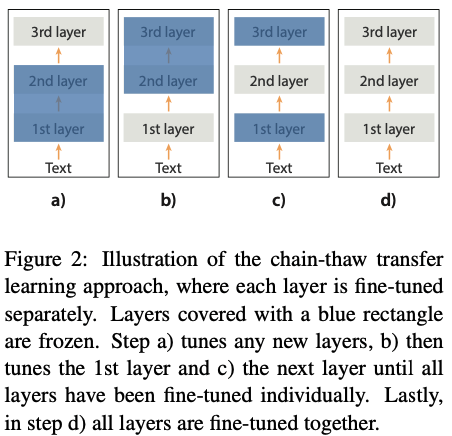

Note on step a) often, only a Softmax layer is added to tackle the target task.

Let's use the DeepMoji algorithm for the kaggle challenge "Detecting Insults in Social Commentary". The challenge was to predict whether a comment posted during a public discussion is considered insulting to one of the participants. (reference : https://www.kaggle.com/c/detecting-insults-in-social-commentary/data)

The data has 2 attributes:
- date: time at which the comment was made (sometimes blank)
- comment: unicode-escaped text of the content, surrounded by double-quotes (mostly english)

Each comment has been given a label:
- 0 for a neutral comment
- 1 for an insulting comment

This is a single class (binary) classification problem.

The dataset has been divided in 2 :
- training dataset: 3947 comments (2898 neutral + 1089 insults) with labels for all comments (supervised learning)
- test dataset: 2235 comments (1158 neutral + 1077 insults)

It is said that this problem tends to strongly overfit.

In [3]:
import pandas as pd

df_train = pd.read_csv("data/train.csv")
df_test  = pd.read_csv("data/test.csv")

print(df_train.shape, df_test.shape)

(3947, 3) (2235, 3)


In [24]:
from deepmoji.model_def import deepmoji_transfer
from deepmoji.finetuning import (
    load_benchmark,
    finetune)

DATASET_PATH = 'data/kaggle-insults/raw.pickle'
nb_classes = 2 # binary classification

with open('model/vocabulary.json', 'r') as f:
    vocab = json.load(f)
print("lets go")
# Load dataset. Extend the existing vocabulary with up to 10000 tokens from
# the training dataset.
print("loading benchmark")
data = load_benchmark(DATASET_PATH, vocab, extend_with=10000)
print("finished")

# Set up model and finetune. Note that we have to extend the embedding layer
# with the number of tokens added to the vocabulary.
model2 = deepmoji_transfer(nb_classes, data['maxlen'], PRETRAINED_PATH,
                          extend_embedding=data['added'])
model2.summary()

old_weights = model2.get_weights()

lets go
loading benchmark
finished
Loading weights for embedding
Extended vocabulary for embedding layer from 50000 to 53545 tokens.
Loading weights for bi_lstm_0
Loading weights for bi_lstm_1
Loading weights for attlayer
Ignoring weights for softmax
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 256)      13707520    input_4[0][0]                    
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 50, 256)      0           embedding[0][0]                  
________________________________________________________

Changes made to the original DeepMoji model :
- added "embed_drop" (SpatialDropout1D layer) with output shape 50x256 -> ?
- added "dropout_1" (Dropout layer) with output shape 2304 -> probably added to limit overfitting, as the kaggle challenge warned that the problem was prone to strongly overfit.
- modified the final softmax layer with only one neuron -> because here for a given comment, the prediction is 0 or 1 (neutral or insult)

In [ ]:
model2, acc = finetune(model, data['texts'], data['labels'], nb_classes,
                      data['batch_size'], method='chain-thaw')
print('Acc: {}'.format(acc))

We trained the model in a separate notebook. It took approximately 1h on a GMM computer with GPU and 2h30 on a computer with CPU.

We get this output:

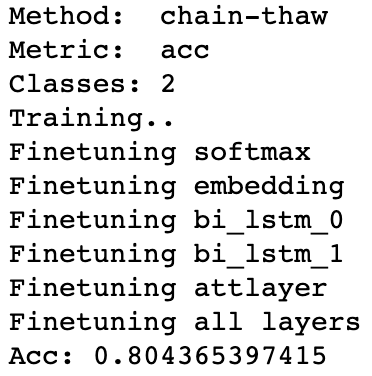

In [25]:
from deepmoji.model_def import load_specific_weights
load_specific_weights(model2, weight_path='/Users/efu/Downloads/model_weight.h5')

Loading weights for embedding
Loading weights for bi_lstm_0
Loading weights for bi_lstm_1
Loading weights for attlayer
Loading weights for softmax


In [38]:
new_weights = model2.get_weights()
print(np.shape(old_weights), np.shape(new_weights))
print(np.array_equal(old_weights,new_weights)) # ok on part sur le fait qu'on a les bons nouveaux weights (d'Emma)

(16,) (16,)
False


In [40]:
# dans les cells suivantes je veux afficher les prédictions avec les commentaires associés,
# car pour l'instant y'a juste l'accuracy totale qui sort... et c'est pas forcément parlant

X_test = data['texts'][2]
X_val = data['texts'][1]

y_test = data['labels'][2]
y_val = data['labels'][1]

y_pred_test = np.array(model2.predict(X_test, batch_size=batch_size)) #predicted outputs of the testing dataset
y_pred_val = np.array(model2.predict(X_val, batch_size=batch_size)) #predicted outputs of the validation dataset

# not sure why the dataset is split that way...

In [55]:
print(y_test)
print(np.shape(y_test))

[0 1 0 ..., 0 1 0]
(1237,)


In [56]:
print(y_pred_test)
print(np.shape(y_pred_test))

[[ 0.18572274]
 [ 0.0921974 ]
 [ 0.02150546]
 ..., 
 [ 0.13255301]
 [ 0.24666344]
 [ 0.16216314]]
(1237, 1)


In [57]:
print(y_val)
print(np.shape(y_val))

[1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0
 1 1 1 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1
 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1 0 0 1
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1
 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1
 0 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0
 0 1 0 1 1 0 1 1 0 0 0 0 

In [58]:
print(y_pred_val)
print(np.shape(y_pred_val))

[[ 0.74774832]
 [ 0.58954734]
 [ 0.44702557]
 [ 0.19908521]
 [ 0.72733957]
 [ 0.06127828]
 [ 0.05342822]
 [ 0.66211557]
 [ 0.36668169]
 [ 0.0949645 ]
 [ 0.90007633]
 [ 0.44641447]
 [ 0.3916322 ]
 [ 0.03745508]
 [ 0.17551222]
 [ 0.96721953]
 [ 0.10665374]
 [ 0.04044033]
 [ 0.11484548]
 [ 0.43390319]
 [ 0.16404432]
 [ 0.91673577]
 [ 0.19712891]
 [ 0.37049168]
 [ 0.14355148]
 [ 0.8530404 ]
 [ 0.04017455]
 [ 0.66848922]
 [ 0.03237037]
 [ 0.81248069]
 [ 0.96624213]
 [ 0.08780755]
 [ 0.10365436]
 [ 0.21109571]
 [ 0.14178918]
 [ 0.14105298]
 [ 0.34989688]
 [ 0.06641418]
 [ 0.81227976]
 [ 0.75332999]
 [ 0.86994928]
 [ 0.11088791]
 [ 0.01604038]
 [ 0.04567565]
 [ 0.68818432]
 [ 0.0155334 ]
 [ 0.28582364]
 [ 0.16428287]
 [ 0.30959061]
 [ 0.55677432]
 [ 0.0621274 ]
 [ 0.12568712]
 [ 0.08047094]
 [ 0.18633406]
 [ 0.31818563]
 [ 0.14481509]
 [ 0.6612615 ]
 [ 0.49890661]
 [ 0.04321804]
 [ 0.34296101]
 [ 0.17501818]
 [ 0.0380348 ]
 [ 0.36691561]
 [ 0.07029819]
 [ 0.0804607 ]
 [ 0.08694906]
 [ 0.61054

## Limits of the Deepmoji algorithm

Some limits or issues related to the algorithm were stated by the authors themselves :
- "For some sentences it can be difficult for the model to see if the text is being ironic or not. In those cases, the most likely emojis are either very positive or very negative."
- "the model has learned about language from the raw, uncurated expressions of individuals on social media. We do not endorse in any way the emotional interpretation that the model has of any particular content."

## References

Paper https://arxiv.org/abs/1708.00524

Blog post https://medium.com/@bjarkefelbo/what-can-we-learn-from-emojis-6beb165a5ea0

Website https://deepmoji.mit.edu/

Code https://github.com/bfelbo/DeepMoji